<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1.-Импорт-библиотек">
                    <span class="toc-item-num">1.&nbsp;&nbsp;</span>
                    Импорт библиотек
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2.-Постановка-задачи">
                    <span class="toc-item-num">2.&nbsp;&nbsp;</span>
                    Постановка задачи
                </a>
            </span>
        </li>
        <li style="margin-top: 10px">
            <span>
                <a href="#3.-Построение-модели">
                    <span class="toc-item-num">3.&nbsp;&nbsp;</span>
                    Построение модели
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1.-Загрузка-набора-данных">
                            <span class="toc-item-num">3.1.&nbsp;&nbsp;</span>
                            Загрузка набора данных
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2.-Визуализация-данных">
                            <span class="toc-item-num">3.2.&nbsp;&nbsp;</span>
                            Визуализация данных
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3.-Построение-нейросетевой-модели">
                            <span class="toc-item-num">3.3.&nbsp;&nbsp;</span>
                            Построение нейросетевой модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4.-Обучение-модели">
                            <span class="toc-item-num">3.4.&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.5.-Ансаблевое-голосование">
                            <span class="toc-item-num">3.5.&nbsp;&nbsp;</span>
                            Ансаблевое голосование
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li style="margin-top: 10px">
            <span>
                <a href="#4.-Общий-вывод">
                    <span class="toc-item-num">4.&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Курсовая работа №1: MPI + PyTorch

**Задача:** совместить MPI и Pytorch: используя ресурсы своего компьютера, кинуть на каждое ядро простую готовую сеть на Pytorch, получить результаты с разных ядер и сделать ансамблевое голосование.

**Источники данных:** MNIST ([HuggingFace](https://huggingface.co/datasets/mnist)).

**Описание данных:** набор данных хранит образцы написания рукописных цифр.

<div style="height: 2px; background-color: blue; margin: 10px 0;"></div>

## 1. Импорт библиотек

In [1]:
from datasets import load_dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.distributed as dist
import torch.utils.data as data_utils
from torch.multiprocessing import Process

from sklearn.ensemble import BaggingClassifier

import torchvision

<div style="height: 2px; background-color: blue; margin: 10px 0;"></div>

## 2. Постановка задачи

Необходимо написать MPI-программу, которая будет раздавать нескольким ядрам задачи и собирать с них результаты произведённых вычислений с помощью ансамблевого голосования.

>**MPI-программа** - это множество параллельных взаимодействующих процессов, которые работают каждый в своей выделенной области памяти.
>
>**MPI** (Message Passing Interface) - 1) стандарт в параллельных вычислениях с распределённой памятью; 2) программный интерфейс (API) для передачи информации, который позволяет обмениваться сообщениями между процессами, выполняющими одну задачу.
>
>**Ансамблирование моделей** (ансамблевое голосование) – использование нескольких моделей вместо одной и объединение их предсказаний (за счёт учёта опыта всех моделей такой подход позволяет уменьшить ошибки).

Задача будет представлять собой классификацию средствами Pytorch набора данных MNIST.

Шаги воспроизведения решения задачи:

1. Написать загрузчик датасета
2. Написать разделитель датасета
3. Сформировать тренировочную и тестовую выборки
4. Отправить на разные ядра разные же части этих выборок
5. Получить результаты и объединить их

<div style="height: 2px; background-color: blue; margin: 10px 0;"></div>

## 3. Построение модели

In [2]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

<div style="height: 2px; background-color: blue; margin: 10px 0; opacity: 0.2"></div>

### 3.1. Загрузка набора данных

Задание функции загрузки набора данных MNIST:

In [3]:
def mnist_dataloader(train: bool = True, 
                     batch_size: int = 64):
    
    """Dataloader of the MNIST dataset
       
       Args:
           train (bool, optional): train of test. Defaults to True
           batch_size (int, optional): batch size. Defaults to 64
       
       Return:
           Loaded MNIST dataset
    """
    
    return data.DataLoader(
               torchvision.datasets.MNIST("./", 
                   train=train, 
                   download=True, 
                   transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                   shuffle=True,
                   num_workers=1,
                   batch_size=batch_size)

Ссылка на python-файл: [mnist_dataloader.py](https://github.com/tidalinn/mai_term01_artificial_intelligence_course/coursework_mpi_01/mnist_dataloader.py).

Определение тренировочного и тестового датасетов:

In [4]:
train_mnist = mnist_dataloader()
test_mnist = mnist_dataloader(False)

c:\python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<div style="height: 2px; background-color: blue; margin: 10px 0; opacity: 0.2"></div>

### 3.2. Визуализация данных

Сохранение тестового набора данных:

In [5]:
examples = enumerate(test_mnist)
batch_idx, (example_data, example_targets) = next(examples)

Выведение на экран размера одного батча:

In [6]:
print('Размер тензора:', example_data.shape)

Размер тензора: torch.Size([64, 1, 28, 28])


Выведение на экран образцов данных датасета:

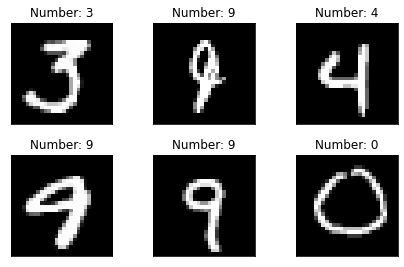

In [7]:
fig = plt.figure()

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f'Number: {example_targets[i]}')
    plt.xticks([])
    plt.yticks([])

plt.show()

<div style="height: 2px; background-color: blue; margin: 10px 0; opacity: 0.2"></div>

### 3.3. Построение нейросетевой модели

Задание класса нейронной сети с двумерной свёрткой и двумя Dropout-регуляризаторами:

In [8]:
class MNISTNetwork(nn.Module):
    def __init__(self):
        super(MNISTNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, 1)

Объявление экземпляра класса:

In [9]:
network = MNISTNetwork()

Задание параметров:

In [10]:
learn_r = 0.01
moment = 0.5
epochs = 2

Определение оптимизатора:

In [11]:
optimizer = optim.SGD(network.parameters(), lr=learn_r, momentum=moment)

Ссылка на python-файл: [mnist_network.py](https://github.com/tidalinn/mai_term01_artificial_intelligence_course/coursework_mpi_01/mnist_network.py).

<div style="height: 2px; background-color: blue; margin: 10px 0; opacity: 0.2"></div>

### 3.4. Обучение модели

Задание функции обучения модели на тренировочном датасете:

In [12]:
def train(epoch, train_set, network, optimizer, log_interval: int = 10):
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_set):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_set.dataset),
                  100. * batch_idx / len(train_set), loss.item()))

Ссылка на python-файл: [train.py](https://github.com/tidalinn/mai_term01_artificial_intelligence_course/coursework_mpi_01/train.py).

Задание функции обучения модели на тестовом датасете:

In [13]:
def test(test_set, network):
    network.eval()
    test_loss = 0
    correct = 0
    results = {'avg_loss': [],
               'accuracy': []}
    
    with torch.no_grad():
        for data, target in test_set:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
    test_loss /= len(test_set.dataset)
    
    results['avg_loss'].append(test_loss)
    results['accuracy'].append(100. * correct / len(test_set.dataset))

    return results

Ссылка на python-файл: [test.py](https://github.com/tidalinn/mai_term01_artificial_intelligence_course/coursework_mpi_01/test.py).

Обучение модели на всех данных:

In [14]:
init_test = test(test_mnist, network)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
          init_test['avg_loss'][0], init_test['accuracy'][0]))

results_test = []

for epoch in range(1, epochs + 1):
    train(epoch, train_mnist, network, optimizer)
    results_test.append(test(test_mnist, network))
    print()

c:\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
c:\python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [12160/60000 (20%)

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.292272
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.292756
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.202214
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.261317
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.354185
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.428840
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.271411
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.340419
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.453894
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.316161
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.337763
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.248534
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.235532
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.194960
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.477535
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.192724
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.382673
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.213257
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.548612
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.465227


Выведение на экран результатов потерь и качества моделей на пройденных эпохах:

In [15]:
for index, result in enumerate(results_test):
    print('Epoch: {}, Test set: Avg. loss: {:.4f}, Accuracy: ({:.2f}%)'.format(
          index + 1, result['avg_loss'][0], result['accuracy'][0]))

Epoch: 1, Test set: Avg. loss: 0.1864, Accuracy: (94.38%)
Epoch: 2, Test set: Avg. loss: 0.1167, Accuracy: (96.31%)


Модель показала хороший результат, поэтому теперь можно разнести её по нескольким ядрам для распределения вычислений.

Ссылка на python-файл: [train_model.py](https://github.com/tidalinn/mai_term01_artificial_intelligence_course/coursework_mpi_01/train_model.py) с распараллеливанием процессов.

<div style="height: 2px; background-color: blue; margin: 10px 0; opacity: 0.2"></div>

### 3.5. Ансаблевое голосование

Сохранение количества использованных ядер:

In [16]:
total_ranks = 4

Сохранение результатов вычислений на разных ядрах:

In [17]:
data_result = pd.read_csv('./results_test.txt', 
                          names=[f'iter {num}' for num in range(1, total_ranks + 1)])

Выведение на экран результатов вычислений:

In [18]:
data_result

,iter 1,iter 2,iter 3,iter 4
0,tensor(93.6700),tensor(95.6800),tensor(96.7300),tensor(97.2200)


Поскольку модель решает задачу классификации, ансамблирование будет произведено путём избрания наибольшего значения из полученных.

Таким образом, наивысшее качество предсказаний модель показала на 4й итерации при обучении на 2м ядре.

<div style="height: 2px; background-color: blue; margin: 10px 0;"></div>

## 4. Общий вывод

Было произведено обучение модели на разных ядрах с помощью MPI, а результат определён с помощью ансамблевого голосования.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        Наверх к содержанию ↑
    </a>
</div>